In [1]:
import requests, bs4
import pandas as pd
import numpy as np
from urllib.parse import unquote
import matplotlib.pyplot as plt

## 워크넷 API

In [3]:
regions = pd.read_excel('../data/_지역코드.xls', header=2)
regions.head()

,카테고리 ID,1 depth,2 depth,3_depth
0,0,지역무관,,
1,11000,서울,,
2,11110,,서울 종로구,
3,11140,,서울 중구,
4,11170,,서울 용산구,


In [4]:
# 시도 단위
regions_gr2 = regions[(regions['1 depth'] != ' ')]
regions_gr2.head()

,카테고리 ID,1 depth,2 depth,3_depth
0,0,지역무관,,
1,11000,서울,,
27,26000,부산,,
44,27000,대구,,
53,28000,인천,,


### 강소기업 정보- 워크넷 API
- selYear: 선정연도
- coNm: 기업명
- sgBrandNm: 강소기업 브랜드명
- alwaysWorkerCnt: 상시 근로자수

In [4]:
# 워크넷 API
My_API_Key = unquote('##############')  # 본인 인증키

# 전체적인 채용공고
data_idx = ['selYear', 'sgBrandNm', 'coNm', 'alwaysWorkerCnt']
value_idx = [[] for _ in range(len(data_idx))]
data = dict(zip(data_idx, value_idx)) # 각 컬럼 초기화
data

{'selYear': [], 'sgBrandNm': [], 'coNm': [], 'alwaysWorkerCnt': []}

In [6]:
# BASE_URL
xmlUrl = f'''http://openapi.work.go.kr/opi/smallGiants/smallGiants.do?authKey={My_API_Key}&returnType=xml'''

# GET > parsing
response = requests.get(xmlUrl).text.encode('utf-8')
xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
smallGiant = xmlobj.find_all("smallGiant")

# 선정연도, 기업명, 브랜드명, 근로자수 parsing
for vals in smallGiant:
    data["selYear"].append(vals.find('selYear').text)
    data["sgBrandNm"].append(vals.find('sgBrandNm').text)
    data["coNm"].append(vals.find('coNm').text)
    data["alwaysWorkerCnt"].append(vals.find('alwaysWorkerCnt').text)

data = pd.DataFrame(data)
data.head()

,selYear,sgBrandNm,coNm,alwaysWorkerCnt
0,2021,기술혁신형 중소기업(이노비즈),주식회사미래금속,14
1,2021,기술혁신형 중소기업(이노비즈),(주)선진인더스트리,31
2,2021,기술혁신형 중소기업(이노비즈),(주)젠티스,26
3,2021,기술혁신형 중소기업(이노비즈),한국에너지종합기술 주식회사,47
4,2021,기술혁신형 중소기업(이노비즈),디지테크정보(주),34


In [16]:
data.to_csv('../data/워크넷_강소기업.csv', index=False, encoding = 'UTF-8-sig')

### 기업형태에 따른 채용공고 - 워크넷 API
- company 회사명
- salTpNm 임금형태
- minSal 최소임금액
- maxSal 최대임금액
- region 근무지역
- holidayTpNm 근무형태
- minEdubg 최소학력
- career 경력
- empTpCd 고용형태코드
- jobsCd 직종코드
- regDt 등록일자
- region_2 시군구
- region_1 시도
- basicAddr 회사 위치
- smCo: 강소기업 여부
- coTp: 기업 형태


In [4]:
gangso = pd.read_csv('../data/워크넷_강소기업.csv')
gangso_list = list(gangso['coNm'])
gangso.head()

,selYear,sgBrandNm,coNm,alwaysWorkerCnt
0,2021,기술혁신형 중소기업(이노비즈),주식회사미래금속,14
1,2021,기술혁신형 중소기업(이노비즈),(주)선진인더스트리,31
2,2021,기술혁신형 중소기업(이노비즈),(주)젠티스,26
3,2021,기술혁신형 중소기업(이노비즈),한국에너지종합기술 주식회사,47
4,2021,기술혁신형 중소기업(이노비즈),디지테크정보(주),34


#### 전체적인 채용공고

In [5]:
My_API_Key = unquote('#########')  # 본인 인증키

# 전체적인 채용공고
data_idx = ['company', 'salTpNm', 'minSal', 'maxSal', 'holidayTpNm', 
            'minEdubg', 'career', 'empTpCd', 'jobsCd', 'regDt', 'closeDt', 'region_1', 'region_2', 
            'basicAddr', 'smCo'] # 회사 주소(basicAddr), 기업 형태(coTp), 강소기업 여부(smCo)
value_idx = [[] for _ in range(len(data_idx))]
data = dict(zip(data_idx, value_idx)) # 각 컬럼 초기화
data

{'company': [],
 'salTpNm': [],
 'minSal': [],
 'maxSal': [],
 'holidayTpNm': [],
 'minEdubg': [],
 'career': [],
 'empTpCd': [],
 'jobsCd': [],
 'regDt': [],
 'closeDt': [],
 'region_1': [],
 'region_2': [],
 'basicAddr': [],
 'smCo': []}

In [7]:
regions_gr2.head()

,카테고리 ID,1 depth,2 depth,3_depth
0,0,지역무관,,
1,11000,서울,,
27,26000,부산,,
44,27000,대구,,
53,28000,인천,,


In [8]:
# 지역별 채용공고 탐색
for row in regions_gr2.iterrows():
    region_code = str(row[1]['카테고리 ID'])
    region = row[1]['1 depth']
    # 채용공고 페이지(1~1000) 탐색
    for page in range(1, 1001):
        # Service URL + 인증키
        xmlUrl = f'''http://openapi.work.go.kr/opi/opi/opia/wantedApi.do?authKey={My_API_Key}\
                &returnType=xml&startPage={page}&display=100&callTp=L&region={region_code}'''

        # GET > parsing
        response = requests.get(xmlUrl).text.encode('utf-8')
        xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
        wanted = xmlobj.find_all("wanted")
        if wanted == []:
            break
        
        # 채용공고 정보 parsing
        for vals in wanted:
            company_name = vals.find('company').text
            data["company"].append(company_name) # 기업명
            data["salTpNm"].append(vals.find('salTpNm').text) # 연봉/월급/일급 구분
            data["minSal"].append(vals.find('minSal').text) # 최소 금액
            data["maxSal"].append(vals.find('maxSal').text) # 최대 금액
            data["holidayTpNm"].append(vals.find('holidayTpNm').text) # 주 근무 일수
            data["minEdubg"].append(vals.find('minEdubg').text) # 최소학력
            data["career"].append(vals.find('career').text) # 최소경력
            data["empTpCd"].append(vals.find('empTpCd').text) # 채용형태 구분 - 정규직, 계약직 등
            data["jobsCd"].append(vals.find('jobsCd').text) # 직무코드
            data["regDt"].append(vals.find('regDt').text) # 공고 등록날짜
            data["closeDt"].append(vals.find('closeDt').text) # 공고 마감날짜
            data["region_1"].append(region) # 시도
            data["region_2"].append(vals.find('region').text) # 시군구
            data["basicAddr"].append(vals.find('basicAddr').text) # 회사 위치

            # 강소기업 구분
            if company_name in gangso_list:
                data["smCo"].append('Y')
            else:
                data["smCo"].append('N')
                
    print(f'{region} 완료')
    
data.head()

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,regDt,closeDt,region_1,region_2,basicAddr,smCo
0,동원펌프주식회사,연봉,26000000,0,주5일근무,학력무관,관계없음,10,16300,22-02-04,채용시까지 22-04-03,지역무관,충북 영동군,충청북도 영동군 용산면 영동산단로 12,N
1,플래티넘크래프트맥주주식회사,연봉,27000000,0,주5일근무,학력무관,관계없음,10,885900,22-02-04,22-02-20,지역무관,충북 증평군,충청북도 증평군 증평읍 울어바위길 79-46,N
2,키즈닥터증평학원,월급,1000000,0,NaN,대졸(4년),관계없음,11,214102,22-02-04,채용시까지 22-04-03,지역무관,충북 증평군,충청북도 증평군 증평읍 초중8길 47-11,N
3,충청북도괴산증평교육지원청,월급,1980000,1980000,주5일근무,학력무관,관계없음,10,231104,22-02-04,22-02-09,지역무관,충북 증평군,충청북도 증평군 증평읍 광장로 152,N
4,충청북도괴산증평교육지원청,월급,1980000,1980000,주5일근무,학력무관,관계없음,10,531202,22-02-04,22-02-09,지역무관,충북 증평군,충청북도 증평군 증평읍 광장로 152,N


In [ ]:
data.to_csv("../data/채용공고_0205.csv", index=False, encoding = 'UTF-8-sig')

#### 기업에 따른 채용 공고

In [ ]:
# 기업별 채용 공고
data_idx = ['company', 'salTpNm', 'minSal', 'maxSal', 'holidayTpNm', 
            'minEdubg', 'career', 'empTpCd', 'jobsCd', 'regDt', 'closeDt', 'region_1', 'region_2', 
            'basicAddr', 'smCo', 'coTp'] # 회사 주소(basicAddr), 기업 형태(coTp), 강소기업 여부(smCo)
value_idx = [[] for _ in range(len(data_idx))]
data = dict(zip(data_idx, value_idx)) # 각 컬럼 초기화
data

In [ ]:
# 기업형태(대기업, 중소기업, 강소기업 등)와 지역별 채용 공고 정보 수집
for comType in ['01','03','04','05','09']: # 기업 형태
    for row in regions_gr2.iterrows(): # 지역
        region_code = str(row[1]['카테고리 ID'])
        region = row[1]['1 depth']
        # 조건에 따른 채용공고 페이지(1~1000) 탐색
        for page in range(1, 1001):
            # Service URL + 인증키
            xmlUrl = f'''http://openapi.work.go.kr/opi/opi/opia/wantedApi.do?authKey={My_API_Key}\
                        &returnType=xml&startPage={page}&display=100&callTp=L&region={region_code}&coTp={comType}'''

            # GET > parsing
            response = requests.get(xmlUrl).text.encode('utf-8')
            xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
            wanted = xmlobj.find_all("wanted")
            if wanted == []:
                break
            
            # 채용공고 정보 parsing
            for vals in wanted:
                company_name = vals.find('company').text
                data["company"].append(company_name) # 기업명
                data["salTpNm"].append(vals.find('salTpNm').text) # 연봉/월급/일급 구분
                data["minSal"].append(vals.find('minSal').text) # 최소 금액
                data["maxSal"].append(vals.find('maxSal').text) # 최대 금액
                data["holidayTpNm"].append(vals.find('holidayTpNm').text) # 주 근무 일수
                data["minEdubg"].append(vals.find('minEdubg').text) # 최소학력
                data["career"].append(vals.find('career').text) # 최소경력
                data["empTpCd"].append(vals.find('empTpCd').text) # 채용형태 구분 - 정규직, 계약직 등
                data["jobsCd"].append(vals.find('jobsCd').text) # 직무코드
                data["regDt"].append(vals.find('regDt').text) # 공고 등록날짜
                data["closeDt"].append(vals.find('closeDt').text) # 공고 마감날짜
                data["region_1"].append(region) # 시도
                data["region_2"].append(vals.find('region').text) # 시군구
                data["basicAddr"].append(vals.find('basicAddr').text) # 회사 위치
                data["coTp"].append(comType) # 기업형태(규모)

                # 강소기업 구분
                if company_name in gangso_list:
                    data["smCo"].append('Y')
                else:
                    data["smCo"].append('N')
                    
        print(f'{region} 완료')
    print(f'{comType} 완료')

In [10]:
data = pd.DataFrame(data.values(), data.keys()).T
data.head()

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,regDt,closeDt,region_1,region_2,basicAddr,smCo,coTp
0,(주)풀무원녹즙,시급,10000,10000,주5일근무,학력무관,관계없음,20,890006,21-12-17,채용시까지 22-02-16,지역무관,충북 증평군,충청북도 증평군 도안면 원명로 35,N,1
1,한국조선해양(주),연봉,35020000,0,주5일근무,대졸(2~3년),관계없음,20,29506,22-02-04,22-02-13,서울,서울 종로구,서울특별시 종로구 율곡로 75,N,1
2,롯데건설㈜,월급,2400000,2600000,주6일근무,학력무관,경력,20,702900,22-02-04,채용시까지 22-03-31,서울,서울 은평구,서울특별시 은평구 수색로 300,N,1
3,(주) 이마트에브리데이,월급,1676280,1795360,주6일근무,고졸,관계없음,11,617902,22-02-03,채용시까지 22-02-20,서울,서울 강남구,서울특별시 강남구 헌릉로 569,N,1
4,(주) 이마트에브리데이,월급,1676280,1795360,주6일근무,고졸,관계없음,11,617902,22-02-03,채용시까지 22-02-20,서울,서울 서초구,서울특별시 서초구 방배로 21,N,1


In [ ]:
data.to_csv("../data/기업형태+채용공고0205.csv", index=False, encoding = 'UTF-8-sig')

### 대쉬보드 서론 분석

In [12]:
data = pd.read_csv("../data/기업형태+채용공고0205.csv")
data.head()

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,regDt,closeDt,region_1,region_2,basicAddr,smCo,coTp
0,(주)풀무원녹즙,시급,10000,10000,주5일근무,학력무관,관계없음,20,890006,21-12-17,채용시까지 22-02-16,지역무관,충북 증평군,충청북도 증평군 도안면 원명로 35,N,1
1,한국조선해양(주),연봉,35020000,0,주5일근무,대졸(2~3년),관계없음,20,29506,22-02-04,22-02-13,서울,서울 종로구,서울특별시 종로구 율곡로 75,N,1
2,롯데건설㈜,월급,2400000,2600000,주6일근무,학력무관,경력,20,702900,22-02-04,채용시까지 22-03-31,서울,서울 은평구,서울특별시 은평구 수색로 300,N,1
3,(주) 이마트에브리데이,월급,1676280,1795360,주6일근무,고졸,관계없음,11,617902,22-02-03,채용시까지 22-02-20,서울,서울 강남구,서울특별시 강남구 헌릉로 569,N,1
4,(주) 이마트에브리데이,월급,1676280,1795360,주6일근무,고졸,관계없음,11,617902,22-02-03,채용시까지 22-02-20,서울,서울 서초구,서울특별시 서초구 방배로 21,N,1


In [13]:
# 데이터 확인
# 기업분류 ==1 (대기업) & 강소기업여부 =='Y' (2021강소기업 리스트에 있는지 여부)
data[(data.coTp == 1) & (data.smCo == 'Y')].head()
# 겹치는 데이터 없음 -> 확인완료

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,regDt,closeDt,region_1,region_2,basicAddr,smCo,coTp


In [16]:
# 강소기업여부와 어떤 기업분류가 겹치는지

# coTp == 3 (벤처기업)
print("벤처기업:", len(data[(data.coTp == 3) & (data.smCo == 'Y')])) # 999

# coTp == 4 (공공기관)
print("공공기관:", len(data[(data.coTp == 4) & (data.smCo == 'Y')])) # 0

# coTp == 5 (외국계기업)
print("외국계기업:", len(data[(data.coTp == 5) & (data.smCo == 'Y')])) # 24

# coTp == 9 (강소기업)
print("강소기업:", len(data[(data.coTp == 9) & (data.smCo == 'Y')])) # 177

# 강소기업은 기업분류(벤처기업, 외국계기업, 강소기업으로 나뉨)

벤처기업: 999
공공기관: 0
외국계기업: 24
강소기업: 177


- 워크넷 채용공고 확인결과, 강소기업은 벤처기업, 외국계기업, 일반 강소기업으로 나뉜다

채용공고의 연봉 구하기
1. 월급, 연봉만 사용
 2. minSal 만 사용
 3. 월급 = 연봉/12
  -> salary(월급)
 4. 이상치 확인

In [18]:
# 1. 월급/연봉 데이터
tmp = data[(data.salTpNm == '연봉') | (data.salTpNm == '월급')]
print("연봉/월급을 포함한 공고:", len(tmp)) #3916
tmp.head(2)

연봉/월급을 포함한 공고: 3916


,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,regDt,closeDt,region_1,region_2,basicAddr,smCo,coTp
1,한국조선해양(주),연봉,35020000,0,주5일근무,대졸(2~3년),관계없음,20,29506,22-02-04,22-02-13,서울,서울 종로구,서울특별시 종로구 율곡로 75,N,1
2,롯데건설㈜,월급,2400000,2600000,주6일근무,학력무관,경력,20,702900,22-02-04,채용시까지 22-03-31,서울,서울 은평구,서울특별시 은평구 수색로 300,N,1


In [21]:
# 2, 3. 최소금액 데이터를 활용하여 월급 계산
tmp['salary'] = 0
for row in tmp.iterrows():
    if row[1]['salTpNm'] == '연봉':
        # print(row)
        tmp.at[row[0],'salary'] = (row[1]['minSal'])/12
    else:
        tmp.at[row[0],'salary'] = (row[1]['minSal'])

tmp.head(2)

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,regDt,closeDt,region_1,region_2,basicAddr,smCo,coTp,salary
1,한국조선해양(주),연봉,35020000,0,주5일근무,대졸(2~3년),관계없음,20,29506,22-02-04,22-02-13,서울,서울 종로구,서울특별시 종로구 율곡로 75,N,1,2.918333e+06
2,롯데건설㈜,월급,2400000,2600000,주6일근무,학력무관,경력,20,702900,22-02-04,채용시까지 22-03-31,서울,서울 은평구,서울특별시 은평구 수색로 300,N,1,2.400000e+06


4. 이상치 및 분포 확인
- 기업분류(coTp)별 박스플랏

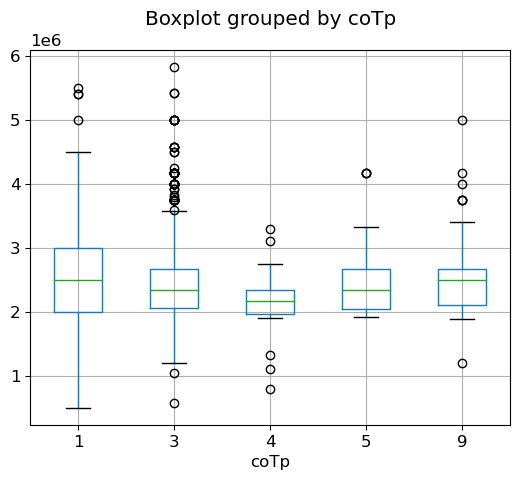

In [34]:
tmp.boxplot('salary', by = 'coTp')
plt.title("")
plt.show()

1 : 대기업<br>
2 : 벤처기업<br>
3 : 공공기관<br>
4 : 외국계<br>
9 : 강소기업<br>
<br>
대기업과 강소기업의 월급 평균이 비슷해보이고 공공기관이 제일 적어보인다.<br>
기업분류별 월급범위는 대기업이 가장 넓고 강소기업과 외국계기업은 최저월급이 높은 편이다.<br>

- 대기업 vs 강소기업 박스플랏<br><br>
대기업 bigCo<br>
강소기업 smallCo

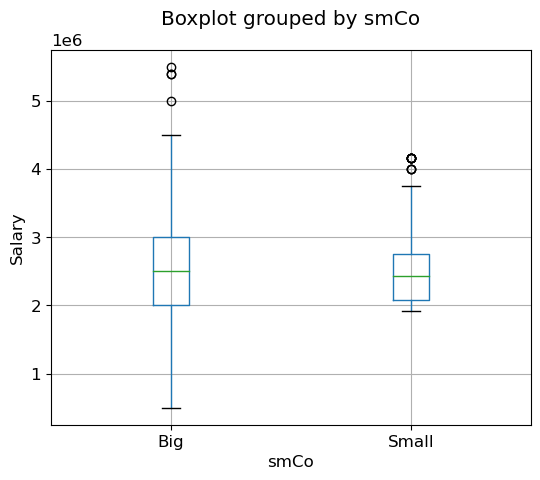

In [49]:
tmp[(tmp.coTp == 1)|(tmp.smCo == 'Y')].boxplot('salary', by = 'smCo')
plt.title("")
plt.xticks([1, 2], labels=['Big', 'Small'])
plt.ylabel("Salary")
plt.show()

In [50]:
# 두 그룹의 연봉의 단순 산술평균
print("대기업 평균월급: ", round(np.mean(tmp[tmp.coTp == 1]['salary'])/10000,0), '만 원')
print("강소기업 평균월급: ", round(np.mean(tmp[tmp.smCo == 'Y']['salary'])/10000,0), '만 원')

대기업 평균월급:  256.0 만 원
강소기업 평균월급:  248.0 만 원


In [51]:
# 두 그룹의 연봉의 중앙값
print("대기업 월급 중앙값: ", round(np.median(tmp[tmp.coTp == 1]['salary'])/10000,0), '만 원')
print("강소기업 월급 중앙값: ", round(np.median(tmp[tmp.smCo == 'Y']['salary'])/10000,0), '만 원')

대기업 월급 중앙값:  250.0 만 원
강소기업 월급 중앙값:  243.0 만 원


**대기업과 강소기업 분포**

박스플롯 결과, 두 그룹의 월급의 범위의 차이가 크다.<br>
대기업의 최저월급보다는 강소기업의 최저월급이 높고, 강소기업의 최고월급보다는 대기업의 최고월급이 높다.<br>
하지만 두 그룹의 평균월급은 각각 대기업이 256만원, 강소기업이 248만원이며 중앙값 또한 큰 차이가 없어보인다.<br>
정확한 비교를 위해 각 그룹의 월급의 이상치를 제거하고, 검정으로 비교한다.

- 이상치 제거 및 비교

In [52]:
# 결측값 먼저 확인
tmp[tmp.salary == 0] # 없음

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,regDt,closeDt,region_1,region_2,basicAddr,smCo,coTp,salary


In [53]:
# 이상치 IQR 방법
def outlier_iqr(data, column): 

    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR : ',iqr)     
    print('lower bound :', lower)     
    print('upper bound :', upper)    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower]    
    
    # 이상치 총 개수 구하기
    return print('총 이상치 개수 :', data1.shape[0] + data2.shape[0])

In [59]:
bigCo = tmp[tmp.coTp == 1] # 대기업
smallCo = tmp[tmp.smCo == 'Y'] # 강소기업

In [60]:
print("대기업 수:", len(bigCo))
outlier_iqr(bigCo,'salary')

대기업 수: 467
IQR :  1000000.0
lower bound : 500000.0
upper bound : 4500000.0
총 이상치 개수 : 4


In [61]:
# 이상치 제거
bigCo2 = bigCo[(bigCo['salary'] < upper) & (bigCo['salary'] >= lower)]
len(bigCo2)

461

In [62]:
print("강소기업 수:", len(smallCo))
outlier_iqr(smallCo,'salary')

강소기업 수: 938
IQR :  666666.6666666667
lower bound : 1083333.333333333
upper bound : 3750000.0
총 이상치 개수 : 10


In [63]:
# 이상치 제거
smallCo2 = smallCo[(smallCo['salary'] < upper) & (smallCo['salary'] >= lower)]
len(smallCo2)

921

In [64]:
# 이상치 제거 후 평균 월급
print("대기업 평균월급: ", round(np.mean(bigCo2['salary'])/10000,0), '만 원')
print("강소기업 평균월급: ", round(np.mean(smallCo2['salary'])/10000,0), '만 원')

대기업 평균월급:  252.0 만 원
강소기업 평균월급:  245.0 만 원


- T-test 두 그룹 간 평균월급 차이

In [66]:
import scipy.stats as stats 

# 그냥 해보는 이상치제거 : z-score 방법 -> 똑같다
# z-score가 3이상인 rows를 제거함. 
bigCo3 = bigCo[(np.abs(stats.zscore(bigCo['salary'])) < 3.5)]
bigCo3.shape

smallCo3 = smallCo[(np.abs(stats.zscore(smallCo['salary'])) < 3.5)]
smallCo3.shape

print("대기업 평균월급: ", round(np.mean(bigCo3['salary'])/10000,0), '만 원')
print("강소기업 평균월급: ", round(np.mean(smallCo3['salary'])/10000,0), '만 원')

대기업 평균월급:  254.0 만 원
강소기업 평균월급:  247.0 만 원


In [67]:
# 등분산검정
big = bigCo2['salary']
small = smallCo2['salary']
print(stats.levene(big, small))
print(stats.fligner(big, small))
print(stats.bartlett(big, small))

# p-value <.0001
# 이분산성

LeveneResult(statistic=127.52516213698783, pvalue=2.392963704974207e-28)
FlignerResult(statistic=120.3705896809789, pvalue=5.2481045893192665e-28)
BartlettResult(statistic=165.19659066401417, pvalue=8.286389331963007e-38)


In [69]:
from scipy import stats
from scipy.stats import ttest_ind
# from scipy.stats import shapiro
# from scipy.stats import levene
# from scipy.stats import bartlett
# from scipy.stats import ttest_ind
# import seaborn as sns

# 이분산 T-test
# ttest_ind(big, small, equal_var=False, alternative='larger') 
# t.test(big, small, var.equal = False)
# 유의수준 5%에서 두 그룹 간 평균월급의 차이 없음

##### ✔ 대기업과 강소기업의 평균월급의 차이가 없다 (p-value = 0.06)

### 채용정보 API
- company 회사명
- salTpNm 임금형태
- minSal 최소임금액
- maxSal 최대임금액
- region 근무지역
- holidayTpNm 근무형태
- minEdubg 최소학력
- career 경력
- empTpCd 고용형태코드
- jobsCd 직종코드
- prefCd 우대조건 -> 제외
- regDt 등록일자
- region_2 시군구
- region_1 시도

In [5]:
regions_gr2.head()

,카테고리 ID,1 depth,2 depth,3_depth
70,30000,대전,,
76,31000,울산,,
82,36110,세종,,
83,41000,경기,,
132,42000,강원,,
151,43000,충북,,


In [5]:
My_API_Key = unquote('##########')  # 본인 인증키

# 추출 컬럼명
data_idx = ['company', 'salTpNm', 'minSal', 'maxSal', 'holidayTpNm', 
            'minEdubg', 'career', 'empTpCd', 'jobsCd', 'regDt', 'region']
value_idx = [[] for _ in range(len(data_idx))]
data = dict(zip(data_idx, value_idx)) # 각 컬럼 초기화
data['region_1'] = []


for row in regions_gr2.iterrows():
    region_code = str(row[1]['카테고리 ID'])
    region = row[1]['1 depth']
    # 1페이지 ~ 1000페이지 탐색
    for page in range(1, 1001):
        # Service URL + 인증키
        xmlUrl = f'''http://openapi.work.go.kr/opi/opi/opia/wantedApi.do?authKey={My_API_Key}\
                        &returnType=xml&startPage={page}&display=100&callTp=L&region={region_code}'''
        
        # GET > parsing
        response = requests.get(xmlUrl).text.encode('utf-8')
        xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
        
        if xmlobj.find("message").text == '정보가 존재하지 않습니다.':
            break
            
        # xml에서 내가 원하는 컬럼 값 data에 저장
        for idx in data_idx:
            cols = xmlobj.find_all(idx)
            for i in range(len(cols)):
                data[idx].append(cols[i].text)
        data['region_1'].extend([region]*len(cols))

    print(f'{region} 완료')

In [ ]:
# API 내 제공되는 region은 region_2로 변경
data = pd.DataFrame(data)
data.rename(columns = {'region':'region_2'}, inplace=True)

# 중복 제거
data.drop_duplicates(keep='last', inplace=True, ignore_index=True)

#### 지역명 수정

In [ ]:
set(data['region_2'][data['region_1'] == '지역무관'])

In [ ]:
# 태블로 형태에 맞춰 데이터 전처리
region_renew = {'지역무관':'', '서울':'서울특별시', '부산':'부산광역시', 
                '대구':'대구광역시', '인천':'인천광역시', '광주':'광주광역시',
                '강원':'강원도', '경기':'경기도', '경남':'경상남도', 
                '경북':'경상북도', '대전':'대전광역시', '세종':'세종특별자치시', 
                '울산':'울산광역시', '전남':'전라남도', '전북':'전라북도', 
                '제주':'제주특별자치도', '충남':'충청남도', '충북':'충청북도'}
                
for region_old, region_new in region_renew.items():
    if region_old == '세종':
        data['region_2'] = np.where(data['region_2'] == '세종', '세종특별자치시', data['region_2'])

    elif region_old == '지역무관':
        data['region_2'] = np.where(data['region_2'] == '충북 영동군', '영동군', data['region_2'])
        data['region_2'] = np.where(data['region_2'] == '충북 증평군', '증평군', data['region_2'])
        data['region_1'] = np.where(data['region_1'] == '지역무관', '충청북도', data['region_1'])
        
    else:
        data['region_2'] = data['region_2'].apply(lambda x : x.split(f'{region_old} ')[-1] if region_old in x else x)

    data['region_1'] = np.where(data['region_1'] == region_old, region_new, data['region_1'])

In [73]:
data.head()

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,prefCd,regDt,region_2,region_1
0,육군남성대체력단력장,월급,1914440,0,주5일근무,학력무관,관계없음,20,616100,NaN,22-01-19,영동군,충청북도
1,농업회사법인동방팜스주식회사,월급,2200000,2500000,주5일근무,대졸(2~3년),경력,20,28405,NaN,22-01-19,증평군,충청북도
2,육군남성대체력단력장,연봉,22973280,0,주5일근무,학력무관,신입,10,901501,NaN,22-01-19,영동군,충청북도
3,추풍령어린이집,월급,1000000,0,주5일근무,학력무관,경력,20,622902,NaN,22-01-19,영동군,충청북도
4,농업회사법인한그루(주),시급,9160,0,주5일근무,학력무관,관계없음,10,873302,NaN,22-01-19,증평군,충청북도


In [ ]:
data.to_excel("../data/채용데이터.xlsx", index=False)

#### 직종 코드 -> 직종명 변환

In [76]:
# 직종 코드 데이터 불러오기
work_type = pd.read_excel('../data/직종코드.xls', header=2)

# 카테고리 ID int형으로 변환(알파벳 섞이면 그냥 pass)
work_type['카테고리 ID'] = work_type['카테고리 ID'].apply(lambda x : int(x) if x.isdigit() else x)

# 빈 값(' ') -> 결측값(nan)으로 바꾸기
for col in work_type.columns[1:]:
    work_type[col] = np.where(work_type[col] == ' ', np.nan, work_type[col])

# 1 depth, 2 depth: 결측값 대체(ffill = 전 값으로 채워넣기)
work_type.fillna(method = "ffill", inplace=True)
work_type.dropna(subset = ['3_depth'], axis=0, inplace=True)
work_type.reset_index(drop=True, inplace=True)
work_type.head()

,카테고리 ID,1 depth,2 depth,3_depth
0,11100,경영·사무·금융·보험,행정·경영·금융·보험 관리직,의회의원·고위공무원 및 공공단체임원
1,11200,경영·사무·금융·보험,행정·경영·금융·보험 관리직,기업 고위임원
2,12100,경영·사무·금융·보험,행정·경영·금융·보험 관리직,정부행정 관리자
3,12200,경영·사무·금융·보험,행정·경영·금융·보험 관리직,경영지원 관리자
4,12201,경영·사무·금융·보험,행정·경영·금융·보험 관리직,경영기획 부서장


In [74]:
data = pd.read_excel('../data/채용데이터.xlsx')
data.head()

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,prefCd,regDt,region_2,region_1
0,육군남성대체력단력장,월급,1914440,0,주5일근무,학력무관,관계없음,20,616100,NaN,22-01-19,영동군,충청북도
1,농업회사법인동방팜스주식회사,월급,2200000,2500000,주5일근무,대졸(2~3년),경력,20,28405,NaN,22-01-19,증평군,충청북도
2,육군남성대체력단력장,연봉,22973280,0,주5일근무,학력무관,신입,10,901501,NaN,22-01-19,영동군,충청북도
3,추풍령어린이집,월급,1000000,0,주5일근무,학력무관,경력,20,622902,NaN,22-01-19,영동군,충청북도
4,농업회사법인한그루(주),시급,9160,0,주5일근무,학력무관,관계없음,10,873302,NaN,22-01-19,증평군,충청북도


In [77]:
for row in data.iterrows():
    try: # 직종코드에 존재하는 직업
        data.at[row[0], 'jobCate_d1'] = work_type[work_type['카테고리 ID'] == row[1]['jobsCd']].iloc[0]['1 depth'] 
        data.at[row[0], 'jobCate_d2'] = work_type[work_type['카테고리 ID'] == row[1]['jobsCd']].iloc[0]['2 depth']
        
    except IndexError: # 직종코드에 존재하지 않는 직업 -> '그 외'로 표현
        data.at[row[0], 'jobCate_d1'] = '그 외'
        data.at[row[0], 'jobCate_d2'] = '그 외'
data.head()

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,prefCd,regDt,region_2,region_1,jobCate_d1,jobCate_d2
0,육군남성대체력단력장,월급,1914440,0,주5일근무,학력무관,관계없음,20,616100,NaN,22-01-19,영동군,충청북도,영업·판매·운전·운송,매장 계산 및 매표
1,농업회사법인동방팜스주식회사,월급,2200000,2500000,주5일근무,대졸(2~3년),경력,20,28405,NaN,22-01-19,증평군,충청북도,경영·사무·금융·보험,무역·운송·자재·구매·생산·품질 사무
2,육군남성대체력단력장,연봉,22973280,0,주5일근무,학력무관,신입,10,901501,NaN,22-01-19,영동군,충청북도,농림어업직,작물재배
3,추풍령어린이집,월급,1000000,0,주5일근무,학력무관,경력,20,622902,NaN,22-01-19,영동군,충청북도,영업·판매·운전·운송,자동차 운전(택시·버스·화물차·기타 자동차)
4,농업회사법인한그루(주),시급,9160,0,주5일근무,학력무관,관계없음,10,873302,NaN,22-01-19,증평군,충청북도,설치·정비·생산-화학·환경·섬유·의복·식품가공,식품가공 기계 조작


#### 데이터 전처리
- 최대 임금이 없는 채용공고는 최소임금으로 통일
- 시급, 일급, 월급, 연봉은 월급으로 통일하며 이상치는 범위에 따라 시급/일급/월급/연봉으로 변경
    - 시급: 10만원 이상이면서 의사가 아닌 직업은 최소 임금에 맞춰 연봉/월급/일급으로 수정
    - 일급: 50만원 이상인 일급은 최소 임금에 맞춰 연봉/월급으로 수정
    - 월급: 1천만원 이상이면서 의사가 아닌 직업은 최소 임금에 맞춰 연봉으로 수정

In [79]:
# 최대 임금 채우기
data['maxSal'] = data.apply(lambda x : x['minSal'] if x['maxSal'] == 0 else x['maxSal'], axis=1)
data.head(2)

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,prefCd,regDt,region_2,region_1,jobCate_d1,jobCate_d2
0,육군남성대체력단력장,월급,1914440,1914440,주5일근무,학력무관,관계없음,20,616100,NaN,22-01-19,영동군,충청북도,영업·판매·운전·운송,매장 계산 및 매표
1,농업회사법인동방팜스주식회사,월급,2200000,2500000,주5일근무,대졸(2~3년),경력,20,28405,NaN,22-01-19,증평군,충청북도,경영·사무·금융·보험,무역·운송·자재·구매·생산·품질 사무


##### 시급 이상치 변경

In [80]:
outliers = data[(data['salTpNm'] == '시급') & (data['minSal'] > 100000) & (data['jobCate_d2'] != '의사·한의사·치과의사')]

# 변경
for row in outliers.iterrows():
    if row[1]['minSal'] > 10000000:
        data.at[row[0], 'salTpNm'] = '연봉'
    elif row[1]['minSal'] > 500000:
        data.at[row[0], 'salTpNm'] = '월급'
    else:
        data.at[row[0], 'salTpNm'] = '일급'

# 재확인
data[(data['salTpNm'] == '시급') & (data['minSal'] > 100000) & (data['jobCate_d2'] != '의사·한의사·치과의사')]

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,prefCd,regDt,region_2,region_1,jobCate_d1,jobCate_d2


In [81]:
# 변경된 시급의 최소/최대 범위
data[data['salTpNm'] == '시급']['minSal'].min(), data[data['salTpNm'] == '시급']['minSal'].max()

(8720, 140000)

##### 일급 이상치 변경

In [82]:
outliers = data[(data['salTpNm'] == '일급') & (data['minSal'] > 500000)]

# 변경
for row in outliers.iterrows():
    if row[1]['minSal'] > 10000000:
        data.at[row[0], 'salTpNm'] = '연봉'

    elif row[1]['minSal'] > 500000:
        data.at[row[0], 'salTpNm'] = '월급'

    else:
        data.at[row[0], 'salTpNm'] = '일급'

# 재확인   
data[(data['salTpNm'] == '일급') & (data['minSal'] > 500000)]

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,prefCd,regDt,region_2,region_1,jobCate_d1,jobCate_d2


In [83]:
# 변경된 일급의 최소/최대 범위
data[data['salTpNm'] == '일급']['minSal'].min(), data[data['salTpNm'] == '일급']['minSal'].max()

(69760, 250000)

##### 월급 이상치 변경
최소 금액 20만원은 워크넷 확인 결과, 주 단위 근무 시간↓ ex. 우유배달, 스쿨버스 등

In [84]:
outliers = data[(data['salTpNm'] == '월급') & (data['minSal'] > 10000000) & (data['jobCate_d2'] != '의사·한의사·치과의사')]

# 변경
for row in outliers.iterrows():
    if row[1]['minSal'] > 10000000:
        data.at[row[0], 'salTpNm'] = '연봉'

# 재확인      
data[(data['salTpNm'] == '월급') & (data['minSal'] > 10000000) & (data['jobCate_d2'] != '의사·한의사·치과의사')]

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,prefCd,regDt,region_2,region_1,jobCate_d1,jobCate_d2


In [85]:
# 변경된 월급의 최소/최대 범위
data[data['salTpNm'] == '월급']['minSal'].min(), data[data['salTpNm'] == '월급']['minSal'].max()

(200000, 15000000)

In [86]:
# 연봉은 이상치 문제 X
data[data['salTpNm'] == '연봉']['minSal'].min(), data[data['salTpNm'] == '연봉']['minSal'].max()

(9600000, 140000000)

##### 연봉/월급/일급/시급 대체
- 연봉 표기: 연봉/12 -> 월급
- 일급 표기: 주 근무 일수가 나와있지 않으면 22일로 계산, 주 근무 일수가 있다면 주 근무 일수 * 4(주) -> 월급
- 시급 표기: 주 근무 일수가 나와있지 않으면 22일*8시간으로 계산, 주 근무 일수가 있다면 주 근무 일수 * 4(주) * 8시간 -> 월급

In [ ]:
# 월급 계산
for row in data.iterrows():
    if row[1]['salTpNm'] == '연봉':
        data.at[row[0], 'minSal'] = row[1]['minSal'] / 12
        data.at[row[0], 'maxSal'] = row[1]['maxSal'] / 12
    
    elif row[1]['salTpNm'] == '일급':
        if str(row[1]['holidayTpNm']) == 'nan':
            cnt = 22
        else:
            cnt = int(row[1]['holidayTpNm'][1:2])*4

        data.at[row[0], 'minSal'] = row[1]['minSal']*cnt
        data.at[row[0], 'maxSal'] = row[1]['maxSal']*cnt

    elif row[1]['salTpNm'] == '시급':
        if str(row[1]['holidayTpNm']) == 'nan':
            cnt = 22*8
        else:
            cnt = int(row[1]['holidayTpNm'][1:2])*4*8

        data.at[row[0], 'minSal'] = row[1]['minSal']*cnt
        data.at[row[0], 'maxSal'] = row[1]['maxSal']*cnt
        
    else:
        pass

data['salTpNm'] = '월급' # 모든 표기는 월급으로 대체
data.to_excel("../data/채용데이터_세부.xlsx", index=False)

#### 채용정보/강소기업 데이터/청년친화 강소기업 데이터와 병합

- 채용정보 기업명 처리

In [100]:
data = pd.read_excel("../data/채용데이터_세부.xlsx")
data.head(2)

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,prefCd,regDt,region_2,region_1,jobCate_d1,jobCate_d2
0,육군남성대체력단력장,월급,1914440,1914440,주5일근무,학력무관,관계없음,20,616100,NaN,22-01-19,영동군,충청북도,영업·판매·운전·운송,매장 계산 및 매표
1,농업회사법인동방팜스주식회사,월급,2200000,2500000,주5일근무,대졸(2~3년),경력,20,28405,NaN,22-01-19,증평군,충청북도,경영·사무·금융·보험,무역·운송·자재·구매·생산·품질 사무


In [101]:
# 다른 데이터와 회사명 통일을 위해 기업명 처리
data['company2'] = data['company'].apply(lambda x:x.replace("주식회사", ""))
data['company2'] = data['company2'].apply(lambda x:x.replace("(주)", ""))
data['company2'] = data['company2'].apply(lambda x:x.replace(" ", ""))
data.head(2)

,company,salTpNm,minSal,maxSal,holidayTpNm,minEdubg,career,empTpCd,jobsCd,prefCd,regDt,region_2,region_1,jobCate_d1,jobCate_d2,company2
0,육군남성대체력단력장,월급,1914440,1914440,주5일근무,학력무관,관계없음,20,616100,NaN,22-01-19,영동군,충청북도,영업·판매·운전·운송,매장 계산 및 매표,육군남성대체력단력장
1,농업회사법인동방팜스주식회사,월급,2200000,2500000,주5일근무,대졸(2~3년),경력,20,28405,NaN,22-01-19,증평군,충청북도,경영·사무·금융·보험,무역·운송·자재·구매·생산·품질 사무,농업회사법인동방팜스


In [102]:
data.to_excel("../data/워크넷데이터_Y2_fin.xlsx", index=False)

- 강소기업 데이터 처리

In [105]:
# 결과.csv 파일: 위도/경도 생성 프로그램에 강소기업리스트 데이터(외부 획득 자료)를 넣어 위도/경도를 추가한 데이터
data_o = pd.read_csv(r"../data/결과.csv", encoding='cp949')
data = data_o.drop(columns=['No'])
data.head(2)

,연번,브랜드명,사업장명,대표자명,업종(중분류),업종(소분류),주소,경도,위도,상태
0,1,신청기업,신영에스아이(주),박형근,출판업,소프트웨어 개발 및 공급업,서울특별시 용산구 원효로35길 25-0 (원효로3가),126.955964,37.534160,정좌표
1,2,신청기업,(주)레드소프트,조용현,출판업,소프트웨어 개발 및 공급업,서울특별시 구로구 디지털로31길 38-21 309호 (이앤씨벤처드림타워3차),126.893713,37.486524,정좌표


In [110]:
# 주소에서 시도 추출
data['시도'] = data['주소'].apply(lambda x:x.split()[0])
data.head(2)

,연번,브랜드명,사업장명,대표자명,업종(중분류),업종(소분류),주소,경도,위도,상태,시도
0,1,신청기업,신영에스아이(주),박형근,출판업,소프트웨어 개발 및 공급업,서울특별시 용산구 원효로35길 25-0 (원효로3가),126.955964,37.534160,정좌표,서울특별시
1,2,신청기업,(주)레드소프트,조용현,출판업,소프트웨어 개발 및 공급업,서울특별시 구로구 디지털로31길 38-21 309호 (이앤씨벤처드림타워3차),126.893713,37.486524,정좌표,서울특별시


In [111]:
# 다른 데이터와 회사명 통일을 위해 기업명 처리
data['사업장명2'] = data['사업장명'].apply(lambda x:x.replace("주식회사", ""))
data['사업장명2'] = data['사업장명2'].apply(lambda x:x.replace("(주)", ""))
data['사업장명2'] = data['사업장명2'].apply(lambda x:x.replace(" ", ""))
data.head(2)

,연번,브랜드명,사업장명,대표자명,업종(중분류),업종(소분류),주소,경도,위도,상태,시도,사업장명2
0,1,신청기업,신영에스아이(주),박형근,출판업,소프트웨어 개발 및 공급업,서울특별시 용산구 원효로35길 25-0 (원효로3가),126.955964,37.534160,정좌표,서울특별시,신영에스아이
1,2,신청기업,(주)레드소프트,조용현,출판업,소프트웨어 개발 및 공급업,서울특별시 구로구 디지털로31길 38-21 309호 (이앤씨벤처드림타워3차),126.893713,37.486524,정좌표,서울특별시,레드소프트


In [112]:
# 시도 변수 ex) 서울 -> 서울특별시

region_renew = {'서울':'서울특별시', '서울시':'서울특별시', 
                '부산':'부산광역시', 
                '대구시':'대구광역시', '대구':'대구광역시',
                '대구광역시중구성내1동(동성로3가)':'대구광역시', 
                '인천':'인천광역시', 
                '광주':'광주광역시', '광주시':'광주광역시',
                '강원':'강원도', '경기':'경기도', '경남':'경상남도', 
                '경북':'경상북도', 
                '대전':'대전광역시', '대전시':'대전광역시', 
                '대전광역시서구둔산2동(둔산동)':'대전광역시', 
                '세종':'세종특별자치시',
                '울산':'울산광역시', '전남':'전라남도', '전북':'전라북도', 
                '제주':'제주특별자치도', '충남':'충청남도', '충북':'충청북도',
                }
                
for region_old, region_new in region_renew.items():
    data['시도'] = np.where(data['시도'] == region_old, region_new, data['시도'])

data['시도'].head(3)

0    서울특별시
1    서울특별시
2      경기도
Name: 시도, dtype: object

In [113]:
data.to_excel("../data/강소기업데이터_fin.xlsx", index=False)

- 청년친화강소기업 데이터 처리

In [124]:
# 22년 청년친화강소기업 데이터: 워크넷 획득 자료
data = pd.read_excel("../data/2022년_청년친화강소기업.xlsx", header=2) 
data.head(2)

,연번,사업장명,사업자등록번호,소재지,업종(대분류),임금,일생활균형,고용안정,비고
0,1,(주)아이퀘스트,1018142433,"서울특별시 구로구 디지털로34길 55, 407호(구로동,코오롱싸이언스밸리)",정보통신업,임금,NaN,NaN,NaN
1,2,주식회사마크애니,1018147345,"서울특별시 중구 퇴계로 286, 10층(쌍림동)",정보통신업,임금,NaN,NaN,NaN


In [125]:
# 시도 parsing
data['시도'] = data['소재지'].apply(lambda x: x.split(' ')[0])

# 사업장명 변환
data['사업장명2'] = data['사업장명'].apply(lambda x:x.replace("주식회사", ""))
data['사업장명2'] = data['사업장명2'].apply(lambda x:x.replace("(주)", ""))
data['사업장명2'] = data['사업장명2'].apply(lambda x:x.replace(" ", ""))
data.head(2)

,연번,사업장명,사업자등록번호,소재지,업종(대분류),임금,일생활균형,고용안정,비고,시도,사업장명2
0,1,(주)아이퀘스트,1018142433,"서울특별시 구로구 디지털로34길 55, 407호(구로동,코오롱싸이언스밸리)",정보통신업,임금,NaN,NaN,NaN,서울특별시,아이퀘스트
1,2,주식회사마크애니,1018147345,"서울특별시 중구 퇴계로 286, 10층(쌍림동)",정보통신업,임금,NaN,NaN,NaN,서울특별시,마크애니


In [126]:
data.to_excel(r"../data/2022청년친화강소기업.xlsx", index=False)

##### 데이터 병합

In [ ]:
# 1. 워크넷 + 강소기업 명단 merge
data_a = pd.read_excel("../data/워크넷데이터_Y2_fin.xlsx")
data_b = pd.read_excel("../data/강소기업데이터_fin.xlsx") 

data_outer = pd.merge(data_b, data_a, left_on=['사업장명2', '시도'], right_on=['company2', 'region_1'], how='outer')
data_outer.to_excel("../data/강소전체데이터_3.xlsx", index=False)

In [128]:
# 2. 워크넷 + 강소기업 명단과 2022 청년친화 강소기업 데이터 merge
data_a = pd.read_excel("../data/강소전체데이터_3.xlsx")
data_b = pd.read_excel("../data/2022청년친화강소기업.xlsx") 

data_outer = pd.merge(data_a, data_b, left_on=['사업장명2', '시도'], right_on=['사업장명2', '시도'], how='outer')
data_outer.to_excel("../data/강소전체데이터_4.xlsx", index=False)

In [130]:
# 3. 변수명 정리
data_o = pd.read_excel("../data/강소전체데이터_4.xlsx")

data = data_o.drop(columns=['연번_y', '사업장명_y', '비고'])
data.rename(columns = {'연번_x':'연번','사업장명_x':'사업장명'},inplace=True)

data.to_excel("../data/강소전체데이터_4.xlsx", index=False)